# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

# Homework 1 - Supervised Deep Learning

# Regression task

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2021-11-21 15:08:06--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3,7K) [text/plain]
Saving to: 'regression_dataset/train_data.csv.4'

     0K ...                                                   100% 7,19M=0,001s

2021-11-21 15:08:06 (7,19 MB/s) - 'regression_dataset/train_data.csv.4' saved [3776/3776]

--2021-11-21 15:08:06--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3,7K) [text/plain]
Saving to: 'regression_dataset/test_data.csv.4'

     0K 

Here we define a simple function to plot the data points

In [3]:
def plot_data(data, label=''):
    fig = plt.figure(figsize=(12,8))
    plt.scatter(data.input, data.label, label=label)
    plt.xlabel('input')
    plt.ylabel('label')
    plt.legend()
    plt.show()

In [4]:
train_data = pd.read_csv('regression_dataset/train_data.csv')
test_data = pd.read_csv('regression_dataset/test_data.csv')

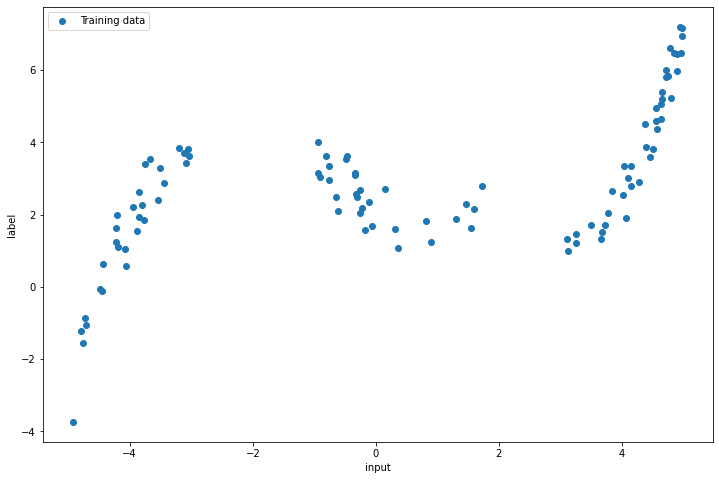

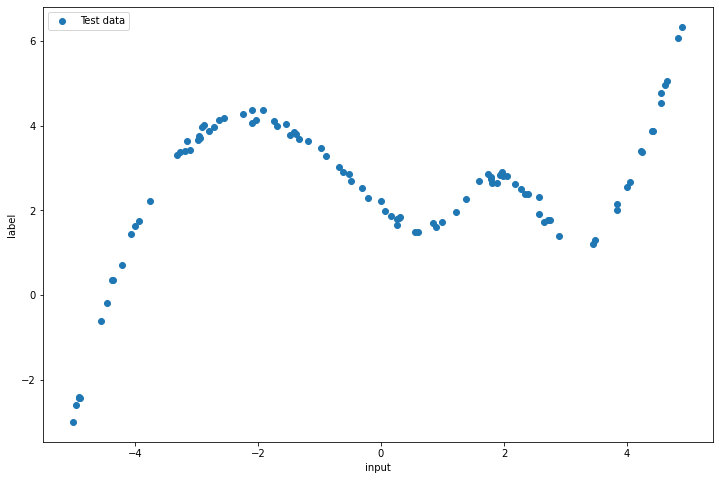

In [5]:
plot_data(train_data, 'Training data')
plot_data(test_data, 'Test data')

Definition of the class CsvDataset, that will open the csv file and put the X's and y's into tuples in order to manage the data in a more convenient way. Note that we have to remove the first line since it contains the string "input output" and the last one since it contains a space " ".

In [6]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        lines.pop(0)
        lines.pop(-1)
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
            # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)
    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [7]:
class ToTensor():
        """Convert sample to Tensors."""
        def __call__(self, sample):
            x, y = sample
            return (torch.tensor([x]).float(), torch.tensor([y]).float())

Now we transform the data into tensors


In [8]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

Here we define the model, which for the regression task will be a very simple network composed ny two hidden layers and the output layer. The activation function is instead a Sigmoid.

In [9]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

In [10]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


Here we initialize the network and pass it to the GPU, if any.

In [11]:

torch.manual_seed(0)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)


Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

Before training the network we analyze the activation and the weights, in ordere to compare the results after the training. 

In [12]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

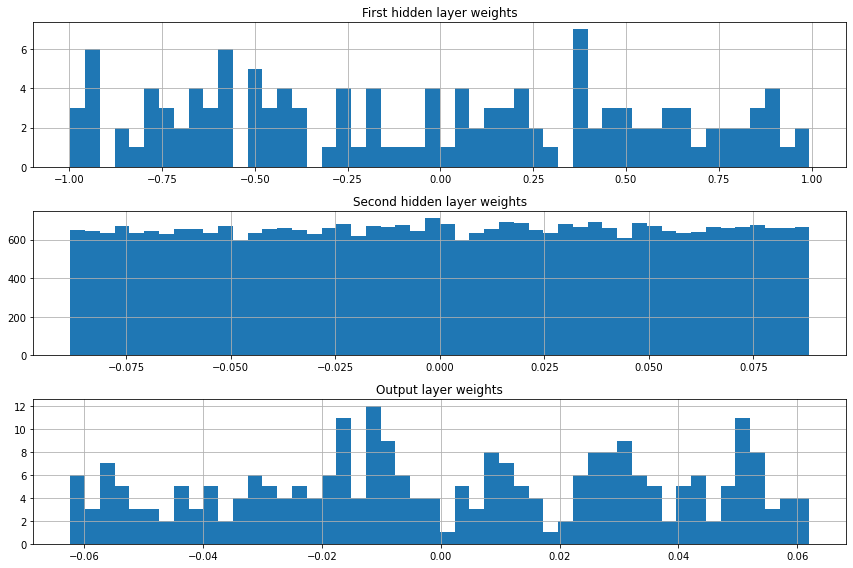

In [13]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

We choose as loss function the Mean Square Error, which is appropriate for regression tasks, while for the moment we will choose SGD as optimizer.

In [14]:
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(net.parameters(), lr = 1e-3)


Training loop for 300 epochs

In [15]:
def train_epoch(net, device, dataset, loss_fn, optimizer): 
    
    net.train() 
    
    for sample_batched in dataset:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        
        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        
        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
        

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    return train_loss, train_loss_log

In [16]:
### TRAINING LOOP
num_epochs = 300
train_loss_log = []
val_loss_log = []

for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in train_dataset:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
        

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)


#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 3.478128671646118
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 3.733461380004883
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 3.2317748069763184
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 3.1839864253997803
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 3.1943836212158203
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 3.175802230834961
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 3.140493392944336
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 3.0994608402252197
#################
# EPOCH 8
#################
AVERAGE TRAIN LOSS: 3.055070161819458
#################
# EPOCH 9
#################
AVERAGE TRAIN LOSS: 3.0078506469726562
#################
# EPOCH 10
#################
AVERAGE TRAIN LOSS: 2.958623170852661
#################
# EPOCH 11
#################
AVERAGE TRAIN LOSS: 2.9

In [17]:
print(train_loss)

0.2668047


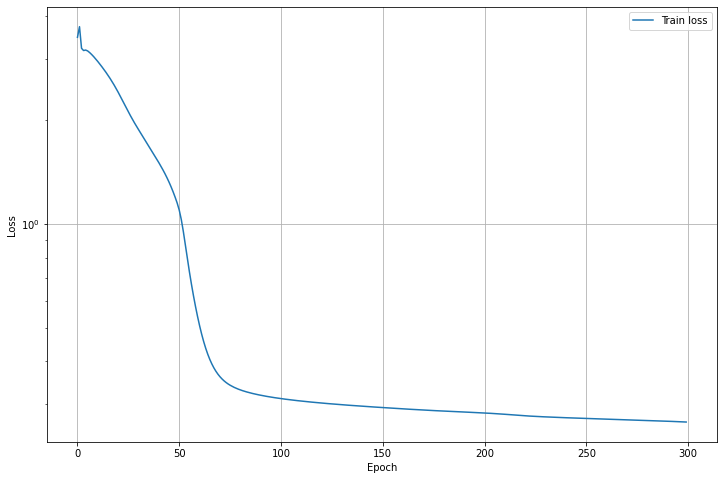

In [18]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
#plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

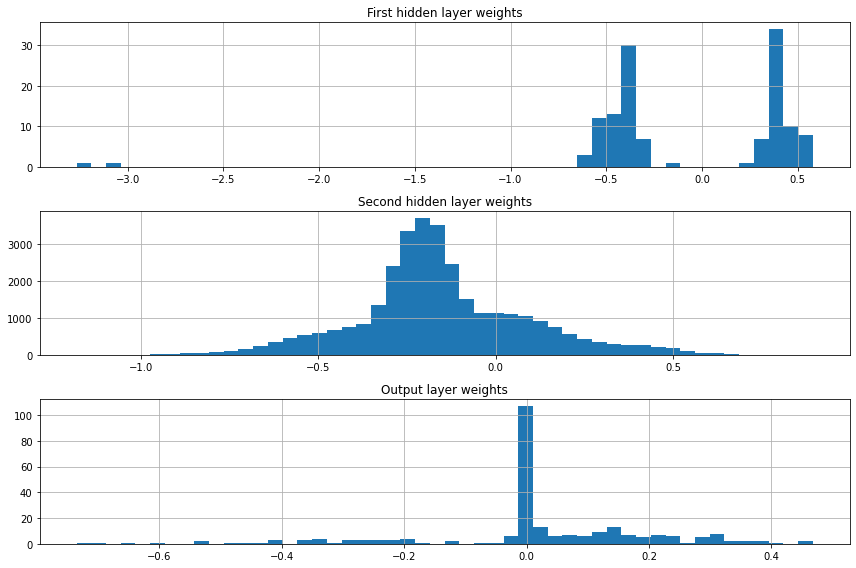

In [19]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()